# Optimizing Hyperparameter Inference: 7.x Binary MPC

## Table of Contents
1. [Set-up](#set-up)
2. [GP-vs-KNN](#GP-vs-KNN): Compare Symmetric GP to KNN
3. [RMSE-Reoptimization](#RMSE-Reoptimization): Reoptimize Hyperparameters using Test RMSE
    - [New-vs-Old-RMSE](#New-vs-Old-RMSE)
    - [Biggest-RMSE-Improvement](#Biggest-RMSE-Improvement)
    - [RMSE-Improvement-vs-Hyper-Change](#RMSE-Improvement-vs-Hyper-Change)
4. [New-Priors](#New-Priors)

## Set-up

Imports:

In [1]:
import os
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt
from tqdm import trange
from scipy.optimize import minimize

os.environ['ADAPTIVE_PREFERENCE_ENV'] = 'dev'

# Step 1: Load the Z data
os.chdir(os.path.expanduser("~/ryandew_adaptive_preference/RA/backend/"))
from data_io.mpc.dataset import z_all

# Step 2: Import the PrefOptim object:
os.chdir(os.path.expanduser("~/ryandew_adaptive_preference/RA/results_analysis/reoptimize_mpc/"))
from og_reopt import PrefOptim

# Step 3: Import useful analysis functions:
os.chdir(os.path.expanduser("~/ryandew_adaptive_preference/RA/results_analysis/reoptimize_mpc/"))
from utils import *


os.chdir(os.path.expanduser("~/ryandew_adaptive_preference/RA/results_analysis/reoptimize_mpc/"))
og_train = pd.read_csv("inputs/7.0_knn_binary_train_df.csv")
og_test = pd.read_csv("inputs/7.0_knn_binary_test_df.csv")


Useful functions:

In [2]:
# Extract training
def extract_train(i):
    train_i = og_train.iloc[i]
    z_shown = z_all[np_str(train_i.items_shown)]
    # Note to self: ratings is the original ratings, no negation
    ratings = np_str(train_i.ratings)
    return z_shown, ratings

def extract_test(i):
    # Extract test
    test_i = og_test.iloc[i]
    random_test_i = eval(test_i['random_test_predictions_ratings'])
    test_items = list(random_test_i.keys())
    old_preds = np.array([a for (a,b) in list(random_test_i.values())])
    test_ratings = np.array([b for (a,b) in list(random_test_i.values())])
    return test_items, test_ratings, old_preds

def extract_sym(i):
    z_shown, ratings = extract_train(i)
    # Compute symmetric z/ratings
    sym_z = np.vstack([z_shown, -z_shown])
    sym_ratings = np.append(ratings, -ratings)
    return sym_z, sym_ratings

def fit_comparison_dict(test_ratings, pred_ratings1, pred_ratings2, index=0):
    return {
        'old_cor': cor(test_ratings, pred_ratings1),
        'new_cor': cor(test_ratings, pred_ratings2),
        'old_sign_acc': sign_acc(test_ratings, pred_ratings1),
        'new_sign_acc': sign_acc(test_ratings, pred_ratings2),
        'old_rmse': rmse(test_ratings, pred_ratings1),
        'new_rmse': rmse(test_ratings, pred_ratings2),
    }

def hyper_comparison_dict(model1, model2, index=0):
    return {
        'old_noise': model1.hypers['noise'],
        'old_amp': model1.hypers['amp'],
        'old_ls': model1.hypers['ls'],
        'new_noise': model2.hypers['noise'],
        'new_amp': model2.hypers['amp'],
        'new_ls': model2.hypers['ls'],
    }


## GP-vs-KNN
**Compare Symmetric GP to KNN**

In [63]:
def refit_person(i, hypers=None):
    # Symmetric training
    sym_z, sym_ratings = extract_sym(i)
    # Extract test
    test_items, test_ratings, old_preds = extract_test(i)

    # Make predictions under new model + sym settings
    new_prefs = PrefOptim(z_shown = sym_z, ratings = sym_ratings)
    if hypers is not None:
        new_prefs.hypers = hypers
    sym_preds_new = new_prefs.compute_utility(z_all[test_items])
    
    fit_i = fit_comparison_dict(test_ratings, old_preds, sym_preds_new)

    return fit_i

for i in range(og_train.shape[0]):   
    fit_data_i = refit_person(i)
    if i == 0:
        fit_data = [fit_data_i]
    else:
        fit_data.append(fit_data_i)

knn_fit_data = pd.DataFrame.from_records(fit_data)

/Users/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [64]:
def print_fit_comparison(fit_data):
    print("fraction strictly better binary acc:", (fit_data['new_sign_acc'] > fit_data['old_sign_acc']).mean())
    print("fraction better or equal binary acc:", (fit_data['new_sign_acc'] >= fit_data['old_sign_acc']).mean())
    print("fraction better cor:", (fit_data['new_cor'] >= fit_data['old_cor']).mean())
    print("fraction better rmse:", (fit_data['new_rmse'] < fit_data['old_rmse']).mean())
    print("new mean cor: ", fit_data['new_cor'].mean())
    print("old mean cor: ", fit_data['old_cor'].mean())
    print("new mean rmse: ", fit_data['new_rmse'].mean())
    print("old mean rmse: ", fit_data['old_rmse'].mean())

print_fit_comparison(knn_fit_data)

fraction strictly better binary acc: 0.5135135135135135
fraction better or equal binary acc: 0.722972972972973
fraction better cor: 0.6756756756756757
fraction better rmse: 0.9459459459459459
new mean cor:  0.2143687354060004
old mean cor:  0.06620819430054388
new mean rmse:  0.48415973658676886
old mean rmse:  0.667323780094536


## RMSE-Reoptimization

**Reoptimize the hyperparameters using test RMSE as loss**

This should give the "upper limit" of improvement based purely on hyperparameters; likely not achievable in online testing

In [5]:

def rmse_under_hypers(hypers_list, prefs, test_z, test_ratings):
    prefs.hypers = {'noise': hypers_list[0], 'amp': hypers_list[1], 'ls': hypers_list[2]}
    pred = prefs.compute_utility(test_z)
    return rmse(pred, test_ratings)

def reoptim_hypers(pars0, prefs, test_z, test_ratings):
    bnds = ((1e-6, 100), (1e-6, 100), (1e-6, 100))
    opt_out = minimize(rmse_under_hypers, pars0, args=(prefs, test_z, test_ratings), method="L-BFGS-B", bounds=bnds)
    return {"noise": opt_out.x[0], "amp": opt_out.x[1], "ls": opt_out.x[2]}

for i in range(og_train.shape[0]):
    z_shown, ratings = extract_train(i)
    z_sym, ratings_sym = extract_sym(i)
    test_items, test_ratings, old_preds = extract_test(i)

    # Make predictions under original settings
    orig_prefs = PrefOptim(z_shown = z_sym, ratings = ratings_sym)
    sym_preds_orig = orig_prefs.compute_utility(z_all[test_items])
    orig_rmse = rmse(test_ratings, sym_preds_orig)

    # Make predictions under new settings
    new_prefs = PrefOptim(z_shown = z_sym, ratings = ratings_sym)
    reoptimed_hypers = reoptim_hypers(
        pars0=[0.1,1,0.5], 
        prefs=new_prefs, 
        test_z=z_all[test_items], 
        test_ratings=test_ratings
    )
    new_prefs.hypers = reoptimed_hypers
    sym_preds_new = new_prefs.compute_utility(z_all[test_items])
    new_rmse = rmse(test_ratings, sym_preds_new)
    
    # Save results in a list
    if i == 0:
        orig_hypers_list = [orig_prefs.hypers]
        reoptimed_hypers_list = [reoptimed_hypers]
        rmse_list = [[orig_rmse, new_rmse]]
        preds_list = [[sym_preds_orig, sym_preds_new]]
    else:
        orig_hypers_list.append(orig_prefs.hypers)
        reoptimed_hypers_list.append(reoptimed_hypers)
        rmse_list.append([orig_rmse, new_rmse])
        preds_list.append([sym_preds_orig, sym_preds_new])
    

reoptim_res_df = pd.DataFrame(reoptimed_hypers_list)
reoptim_res_df['old_noise'] = [a['noise'] for a in orig_hypers_list]
reoptim_res_df['old_amp'] = [a['amp'] for a in orig_hypers_list]
reoptim_res_df['old_ls'] = [a['ls'] for a in orig_hypers_list]
reoptim_res_df['old_rmse'] = [a[0] for a in rmse_list]
reoptim_res_df['new_rmse'] = [a[1] for a in rmse_list]
reoptim_res_df['old_preds'] = [a[0] for a in preds_list]
reoptim_res_df['new_preds'] = [a[1] for a in preds_list]

### New-vs-old-RMSE

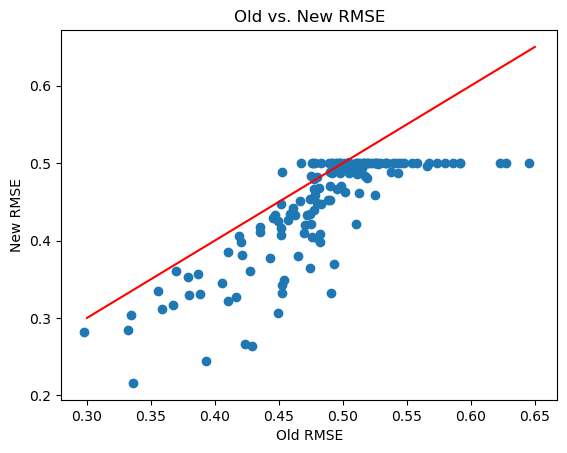

In [6]:
plt.scatter(reoptim_res_df['old_rmse'], reoptim_res_df['new_rmse'])
x = np.linspace(0.3, 0.65, 100)
plt.plot(x, x, color='red')
plt.xlabel("Old RMSE")
plt.ylabel("New RMSE")
plt.title("Old vs. New RMSE")
plt.show()

A key observation here is that RMSE above 0.5 is basically worse than a constant. So, when we reoptimize things, it will set a bunch of impossible-to-predict people to a constant.

### Biggest-RMSE-Improvement

How does the person with the biggest improvement change?

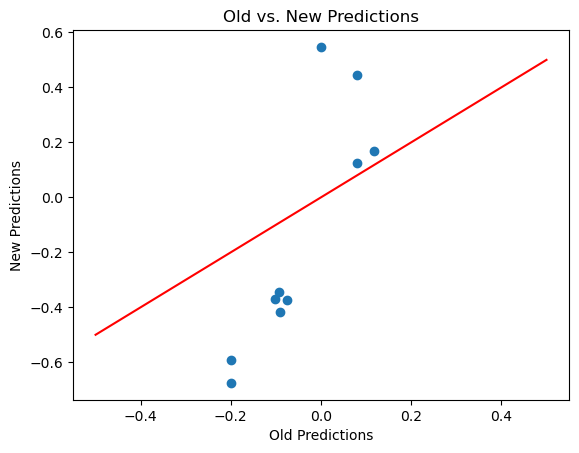

In [7]:
# Sort reoptim_res_df by difference between old_rmse and new_rmse
reoptim_res_df['rmse_diff'] = reoptim_res_df['new_rmse'] - reoptim_res_df['old_rmse']
reoptim_res_df = reoptim_res_df.sort_values(by='rmse_diff', ascending=True)
reoptim_res_df

# Plot the old and new predictions for the person with the largest rmse_diff
i = reoptim_res_df.index[0]
plt.scatter(reoptim_res_df['old_preds'][i], reoptim_res_df['new_preds'][i])
# Add a line x=y
x = np.linspace(-0.5, 0.5, 100)
plt.plot(x, x, color='red')
plt.xlabel("Old Predictions")
plt.ylabel("New Predictions")
plt.title("Old vs. New Predictions")
plt.show()

It looks like it's really just about variance, scaling. I still don't really understand why that happens...

In [8]:
print('noise change:\n', reoptim_res_df.iloc[0][['old_noise','noise']], '\n\n')
print('amp change:\n', reoptim_res_df.iloc[0][['old_amp','amp']], '\n\n')
print('ls change:\n', reoptim_res_df.iloc[0][['old_ls','ls']], '\n\n')

noise change:
 old_noise    0.444974
noise        0.262096
Name: 129, dtype: object 


amp change:
 old_amp    0.220474
amp        1.002081
Name: 129, dtype: object 


ls change:
 old_ls    0.857435
ls        1.033884
Name: 129, dtype: object 




Basically it looks like the amplitude is too low, and the noise is too high. This makes some amount of sense.

### RMSE-Improvement-vs-Hyper-Change

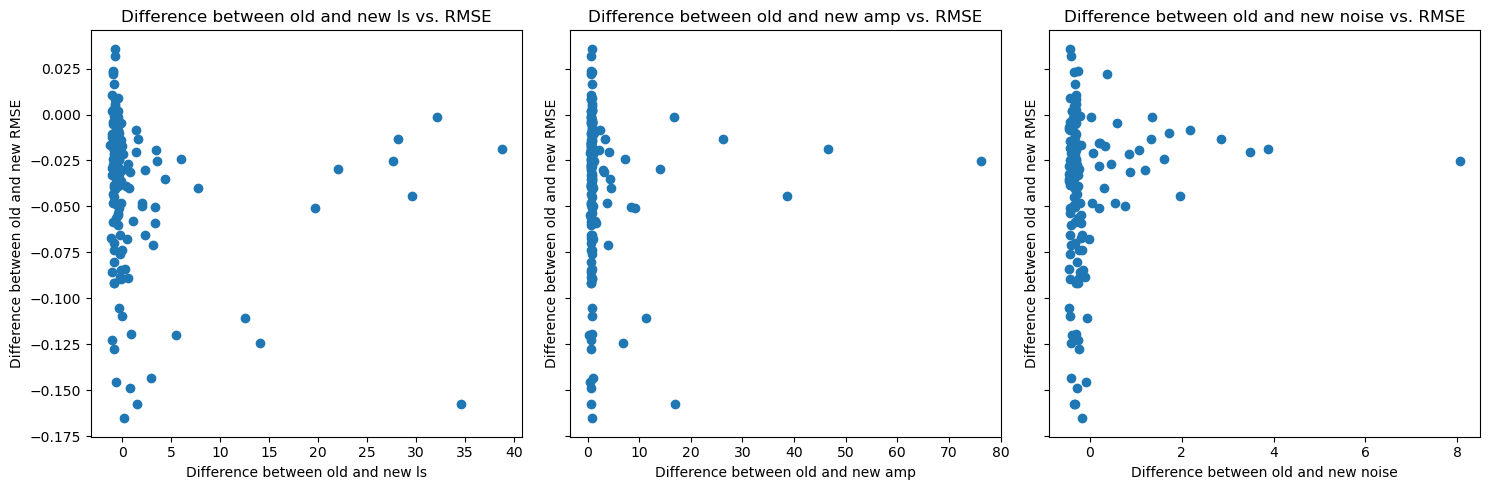

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5))
axs[0].scatter(reoptim_res_df['ls'] - reoptim_res_df['old_ls'], reoptim_res_df['rmse_diff'])
axs[0].set_xlabel("Difference between old and new ls")
axs[0].set_ylabel("Difference between old and new RMSE")
axs[0].set_title("Difference between old and new ls vs. RMSE")
axs[1].scatter(reoptim_res_df['amp'] - reoptim_res_df['old_amp'], reoptim_res_df['rmse_diff'])
axs[1].set_xlabel("Difference between old and new amp")
axs[1].set_ylabel("Difference between old and new RMSE")
axs[1].set_title("Difference between old and new amp vs. RMSE")
axs[2].scatter(reoptim_res_df['noise'] - reoptim_res_df['old_noise'], reoptim_res_df['rmse_diff'])
axs[2].set_xlabel("Difference between old and new noise")
axs[2].set_ylabel("Difference between old and new RMSE")
axs[2].set_title("Difference between old and new noise vs. RMSE")
plt.show()

It seems like there is some benefit of looking at higher values of some of these parameters. That being said, some of this doesn't make actual sense. For instance, the max noise should be 0.5. 

### Optimal-Hyper-Dists

Plot the distributions of the optimal hyperparameters

In [10]:
# Plot the distribution of all ls, amp, and noise using subplots
def plot_hyper_dists(res_df):
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
    axs[0].hist(res_df['ls'], bins=20)
    axs[0].set_xlabel("ls")
    axs[0].set_ylabel("Frequency")
    axs[0].set_title("Distribution of ls")
    axs[1].hist(res_df['amp'], bins=20)
    axs[1].set_xlabel("amp")
    axs[1].set_ylabel("Frequency")
    axs[1].set_title("Distribution of amp")
    axs[2].hist(res_df['noise'], bins=20)
    axs[2].set_xlabel("noise")
    axs[2].set_ylabel("Frequency")
    axs[2].set_title("Distribution of noise")
    plt.show()


Dists for all people:

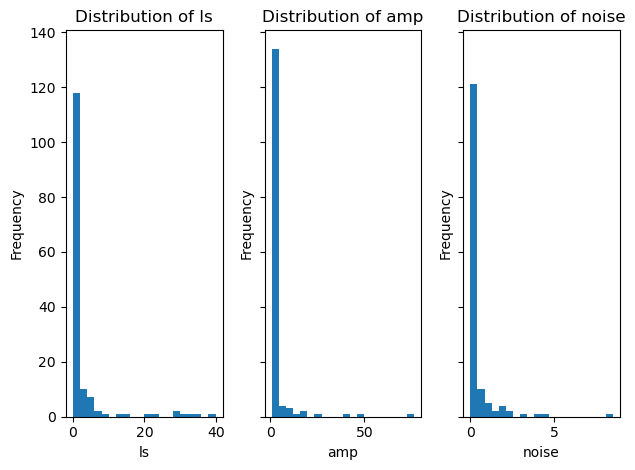

In [11]:
plot_hyper_dists(reoptim_res_df)

Dists for just improved people:

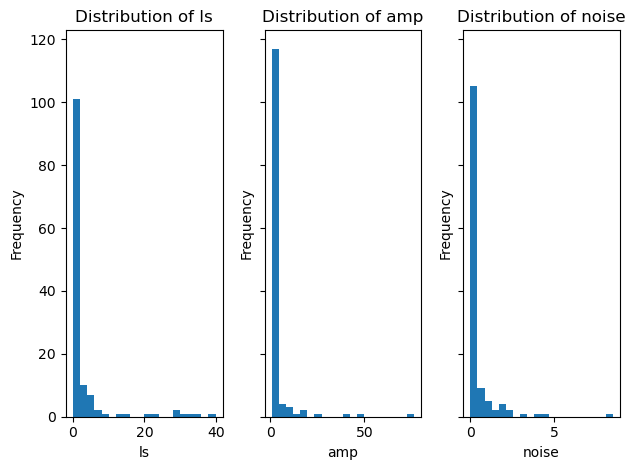

In [12]:
plot_hyper_dists(reoptim_res_df[reoptim_res_df['rmse_diff'] < 0])

Dists for top-50 people:

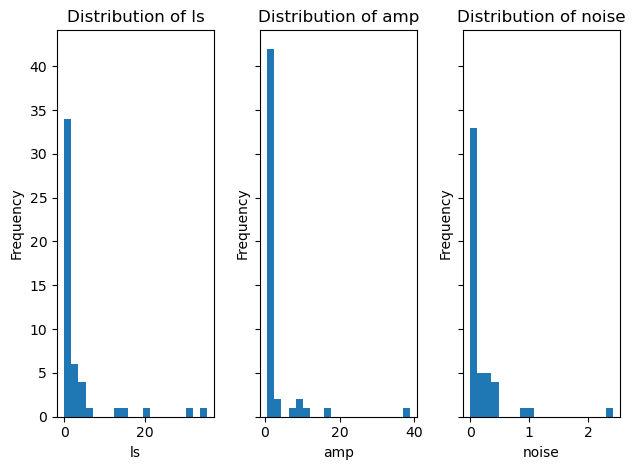

In [13]:
plot_hyper_dists(reoptim_res_df.iloc[0:50])

In all cases, it looks like there's a longer tail than we previously thought.

Let's summarize the distribution of all these optimal hyperparameters:

In [14]:
reoptim_res_df[reoptim_res_df['rmse_diff'] < 0].describe()

,noise,amp,ls,old_noise,old_amp,old_ls,old_rmse,new_rmse,rmse_diff
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,0.418419,3.308160,3.015171,0.402286,0.267635,0.961970,0.484232,0.439485,-0.044746
std,1.018684,8.902122,7.422594,0.056668,0.057640,0.155418,0.061003,0.070899,0.038780
min,0.000001,0.672774,0.000001,0.190332,0.187773,0.670711,0.297661,0.216107,-0.165272
25%,0.000001,0.998820,0.132420,0.374134,0.221681,0.843407,0.452068,0.404453,-0.059587
50%,0.109125,1.007732,0.540228,0.418492,0.254250,0.953234,0.493352,0.466895,-0.032649
75%,0.261642,1.164667,1.568207,0.445450,0.305713,1.063377,0.518252,0.500000,-0.017305
max,8.477269,76.528394,39.957677,0.471757,0.449870,1.539698,0.645454,0.500000,-0.000537


## New-Priors

### Attempt-1

Here, I'll use a new prior that allows for longer tails, and also restricts the noise to be small (0.5, which is the standard deviation of randomly drawn numbers from [-0.5, 0.5]).

- Noise: Gamma with a=5, scale=20, which puts most of the mass around 0.25, and not much mass above 0.5
- Amp: Inverse-Gamma with a=2, scale=0.5
- LS: Inverse-Gamma with a=2, scale=2

In [80]:
for i in trange(og_train.shape[0]):
    z_shown, ratings = extract_train(i)
    z_sym, ratings_sym = extract_sym(i)
    test_items, test_ratings, old_preds = extract_test(i)

    # Make predictions under original settings
    orig_prefs = PrefOptim(
        z_shown = z_sym, 
        ratings = ratings_sym,
        init = [0.1, 1, 0.1],
    )
    sym_preds_orig = orig_prefs.compute_utility(z_all[test_items])
    orig_rmse = rmse(test_ratings, sym_preds_orig)

    # Make predictions under new settings
    new_prefs = PrefOptim(
        z_shown = z_sym, 
        ratings = ratings_sym, 
        init = [0.1, 1, 0.1],
        addl_optim_args = {
            "noise_prior": {"a": 5, "scale": 20},
            "amp_prior": {"a": 1.5, "scale": 3},
            "ls_prior": {"a": 1.5, "scale": 3}
        }
    )
    new_hypers = new_prefs.hypers
    sym_preds_new = new_prefs.compute_utility(z_all[test_items])

    fit_data_i = fit_comparison_dict(test_ratings, sym_preds_orig, sym_preds_new)
    fit_data_i.update(hyper_comparison_dict(orig_prefs, new_prefs))
    fit_data_i.update({'cor_bw_old_new': cor(sym_preds_orig, sym_preds_new)})
    
    # Save results in a list
    if i == 0:
        combined_data = [fit_data_i]
    else:
        combined_data.append(fit_data_i)

new_prior_fit = pd.DataFrame.from_records(combined_data)


 77%|███████▋  | 114/148 [00:23<00:07,  4.51it/s]/Users/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 148/148 [00:31<00:00,  4.68it/s]


In [81]:
print_fit_comparison(new_prior_fit)

fraction strictly better binary acc: 0.2635135135135135
fraction better or equal binary acc: 0.7567567567567568
fraction better cor: 0.5472972972972973
fraction better rmse: 0.4797297297297297
new mean cor:  0.2398320007273758
old mean cor:  0.2143686705251004
new mean rmse:  0.489241519791514
old mean rmse:  0.48415972593792106


(array([ 1.,  0.,  1.,  1.,  1.,  1.,  3., 14., 29., 97.]),
 array([0.26365253, 0.33650561, 0.40935869, 0.48221176, 0.55506484,
        0.62791791, 0.70077099, 0.77362406, 0.84647714, 0.91933022,
        0.99218329]),
 <BarContainer object of 10 artists>)

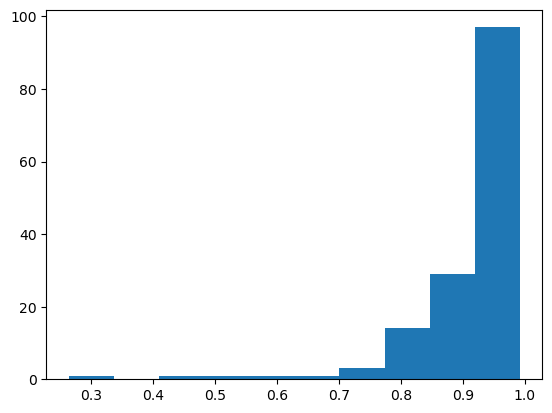

In [84]:
plt.hist(new_prior_fit['cor_bw_old_new'])

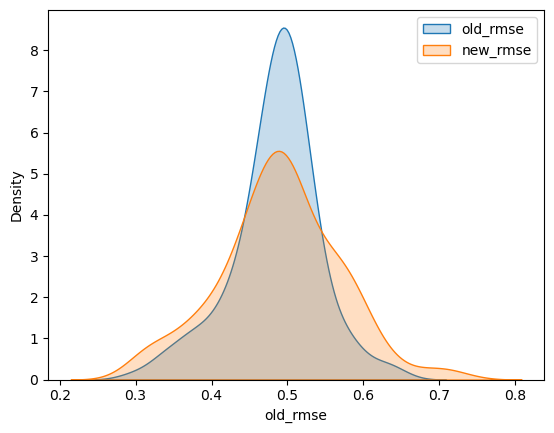

In [82]:
# Plot the distribution of new_rmse vs old_rmse as density plots
import seaborn as sns
sns.kdeplot(new_prior_fit['old_rmse'], fill=True)
sns.kdeplot(new_prior_fit['new_rmse'], fill=True)
plt.legend(labels=['old_rmse', 'new_rmse'])

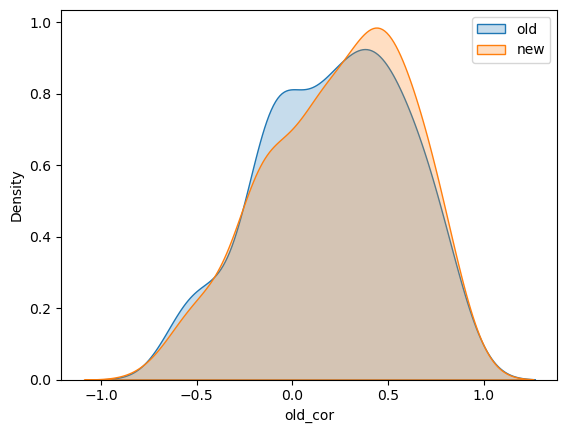

In [69]:
# Plot the distribution of new_rmse vs old_rmse as density plots
import seaborn as sns
sns.kdeplot(new_prior_fit['old_cor'], fill=True)
sns.kdeplot(new_prior_fit['new_cor'], fill=True)
plt.legend(labels=['old', 'new'])

<Axes: xlabel='old_sign_acc', ylabel='Density'>

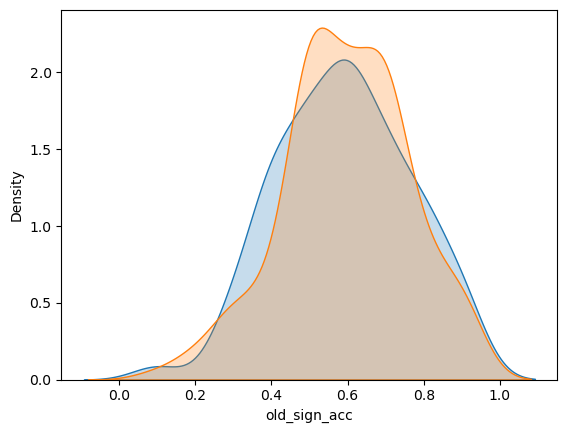

In [70]:
# Plot the distribution of sign_acc 
import seaborn as sns
sns.kdeplot(new_prior_fit['old_sign_acc'], fill=True)
sns.kdeplot(new_prior_fit['new_sign_acc'], fill=True)

Oddly enough, most of these statistics don't really improve with the better priors. But the accuracy does. 

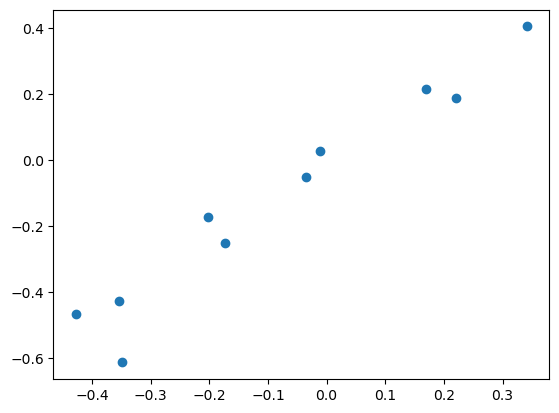

In [79]:
# Plot scatterplot of predicted old vs new ratings
plt.scatter(sym_preds_orig, sym_preds_new)

### Plot-priors

**Length-scale prior**

/var/folders/4r/l9kj4wmj7rx3hjwq2vqrshg00000gq/T/ipykernel_76501/1611553558.py:5: RuntimeWarning: divide by zero encountered in log
  return -(a+1) * np.log(x) - sc.gammaln(a) - b/x + a * np.log(b)
/var/folders/4r/l9kj4wmj7rx3hjwq2vqrshg00000gq/T/ipykernel_76501/1611553558.py:5: RuntimeWarning: divide by zero encountered in divide
  return -(a+1) * np.log(x) - sc.gammaln(a) - b/x + a * np.log(b)
/var/folders/4r/l9kj4wmj7rx3hjwq2vqrshg00000gq/T/ipykernel_76501/1611553558.py:5: RuntimeWarning: invalid value encountered in subtract
  return -(a+1) * np.log(x) - sc.gammaln(a) - b/x + a * np.log(b)


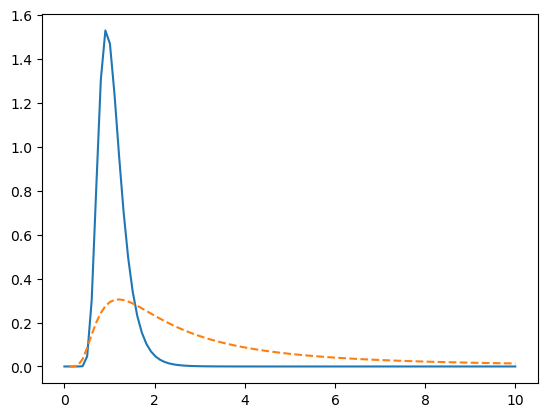

In [74]:
# Prior for length-scale
def invgamma_lpdf(x, a, b):
    # def from: https://distribution-explorer.github.io/continuous/inverse_gamma.html
    # f(x; a, b) = (b^a / Gamma(a)) * x^(-a-1) * exp(-b/x)
    return -(a+1) * np.log(x) - sc.gammaln(a) - b/x + a * np.log(b)

from scipy.stats import invgamma
x = np.linspace(0, 10, 100)
plt.plot(x, invgamma.pdf(x, a=14, scale=14))
plt.plot(x, np.exp(invgamma_lpdf(x, a=1.5, b=3)), "--")
plt.show()

**Amplitude prior**

/var/folders/4r/l9kj4wmj7rx3hjwq2vqrshg00000gq/T/ipykernel_76501/3523167780.py:6: RuntimeWarning: divide by zero encountered in log
  return -(a+1) * np.log(x) - sc.gammaln(a) - b/x + a * np.log(b)
/var/folders/4r/l9kj4wmj7rx3hjwq2vqrshg00000gq/T/ipykernel_76501/3523167780.py:6: RuntimeWarning: divide by zero encountered in divide
  return -(a+1) * np.log(x) - sc.gammaln(a) - b/x + a * np.log(b)
/var/folders/4r/l9kj4wmj7rx3hjwq2vqrshg00000gq/T/ipykernel_76501/3523167780.py:6: RuntimeWarning: invalid value encountered in subtract
  return -(a+1) * np.log(x) - sc.gammaln(a) - b/x + a * np.log(b)


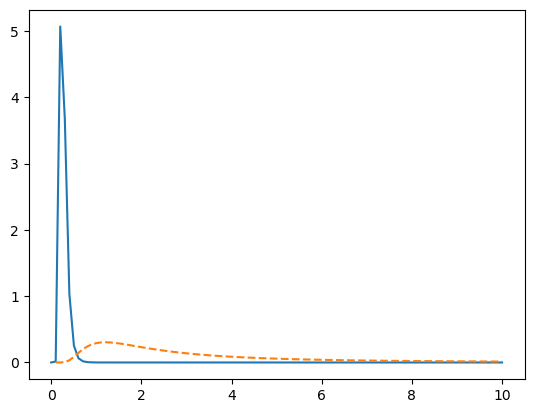

In [75]:
import scipy.special as sc

def invgamma_lpdf(x, a, b):
    # def from: https://distribution-explorer.github.io/continuous/inverse_gamma.html
    # f(x; a, b) = (b^a / Gamma(a)) * x^(-a-1) * exp(-b/x)
    return -(a+1) * np.log(x) - sc.gammaln(a) - b/x + a * np.log(b)

from scipy.stats import invgamma
x = np.linspace(0, 10, 100)
plt.plot(x, invgamma.pdf(x, a=12, scale=3))
plt.plot(x, np.exp(invgamma_lpdf(x, a=1.5, b=3)), "--")
plt.show()

## Optimal-aggregate-hypers

In [99]:
### Optimal-using-RMSE

In [87]:
def average_rmse(hypers_list, z_train_list, ratings_train_list, z_test_list, ratings_test_list):
    # Compute average rmse across all people
    tot_rmse = 0
    N = len(z_train_list)
    for i in range(N):
        prefs = PrefOptim(
            z_shown = z_train_list[i], 
            ratings = ratings_train_list[i]
        )
        prefs.hypers = {'noise': hypers_list[0], 'amp': hypers_list[1], 'ls': hypers_list[2]}
        pred = prefs.compute_utility(z_test_list[i])
        tot_rmse += rmse(pred, ratings_test_list[i])
    return tot_rmse / N

def optimize_average_rmse(pars0, z_train_list, ratings_train_list, z_test_list, ratings_test_list):
    bnds = ((1e-6, 100), (1e-6, 100), (1e-6, 100))
    opt_out = minimize(
        average_rmse, 
        pars0, 
        args=(z_train_list, ratings_train_list, z_test_list, ratings_test_list), 
        method="L-BFGS-B", 
        bounds=bnds
    )
    return {"noise": opt_out.x[0], "amp": opt_out.x[1], "ls": opt_out.x[2]}

# Compute optimal aggregate RMSE:
z_train_list = []
ratings_train_list = []
z_test_list = []
ratings_test_list = []
for i in range(og_train.shape[0]):
    z_sym, ratings_sym = extract_sym(i)
    test_items, test_ratings, old_preds = extract_test(i)
    z_train_list.append(z_sym)
    ratings_train_list.append(ratings_sym)
    z_test_list.append(z_all[test_items])
    ratings_test_list.append(test_ratings)


In [88]:
agg_hypers = optimize_average_rmse(
    pars0=[0.1,1,0.5], 
    z_train_list=z_train_list, 
    ratings_train_list=ratings_train_list, 
    z_test_list=z_test_list, 
    ratings_test_list=ratings_test_list
)

In [89]:
agg_hypers

{'noise': 3.678431205357668, 'amp': 2.281436274433045, 'ls': 1.754546714840787}

In [91]:
average_rmse(
    [agg_hypers['noise'], agg_hypers['amp'], agg_hypers['ls']], 
    z_train_list, 
    ratings_train_list, 
    z_test_list, 
    ratings_test_list
)

0.4820282405759481

In [92]:
def pred(i, hypers=None):
    # Symmetric training
    sym_z, sym_ratings = extract_sym(i)

    # Make predictions under new model + sym settings
    new_prefs = PrefOptim(z_shown = sym_z, ratings = sym_ratings)
    if hypers is not None:
        new_prefs.hypers = hypers
    return new_prefs.compute_utility(z_all[test_items])


In [98]:

pred(5, agg_hypers)

array([-0.17137027,  0.10481969,  0.09361883,  0.01037574,  0.06377453,
       -0.02578047, -0.0895548 , -0.12563631, -0.0164241 ,  0.34764056])

### Optimal-using-acc

In [111]:
def neg_average_acc(hypers_list, z_train_list, ratings_train_list, z_test_list, ratings_test_list):
    tot_acc = 0
    N = len(z_train_list)
    for i in range(N):
        prefs = PrefOptim(
            z_shown = z_train_list[i], 
            ratings = ratings_train_list[i]
        )
        prefs.hypers = {'noise': hypers_list[0], 'amp': hypers_list[1], 'ls': hypers_list[2]}
        pred = prefs.compute_utility(z_test_list[i])
        tot_acc += sign_acc(pred, ratings_test_list[i])
    return -tot_acc / N

def optimize_average_acc(pars0, z_train_list, ratings_train_list, z_test_list, ratings_test_list):
    bnds = ((1e-6, 100), (1e-6, 100), (1e-6, 100))
    opt_out = minimize(
        neg_average_acc, 
        pars0, 
        args=(z_train_list, ratings_train_list, z_test_list, ratings_test_list), 
        method="L-BFGS-B", 
        bounds=bnds
    )
    return {"noise": opt_out.x[0], "amp": opt_out.x[1], "ls": opt_out.x[2]}

# Compute optimal aggregate RMSE:
z_train_list = []
ratings_train_list = []
z_test_list = []
ratings_test_list = []
for i in range(og_train.shape[0]):
    z_sym, ratings_sym = extract_sym(i)
    test_items, test_ratings, old_preds = extract_test(i)
    z_train_list.append(z_sym)
    ratings_train_list.append(ratings_sym)
    z_test_list.append(z_all[test_items])
    ratings_test_list.append(test_ratings)


In [112]:
agg_hypers_acc = optimize_average_acc(
    pars0=[0.1,1,0.5], 
    z_train_list=z_train_list, 
    ratings_train_list=ratings_train_list, 
    z_test_list=z_test_list, 
    ratings_test_list=ratings_test_list
)

In [113]:
agg_hypers_acc

{'noise': 0.1, 'amp': 1.0, 'ls': 0.5}

In [128]:
-neg_average_acc([0.0001,1e-10,1e10], z_train_list, ratings_train_list, z_test_list, ratings_test_list)

0.4912162162162164

In [127]:
pred(0, {'noise': 0.0001, 'amp': 0.001, 'ls': 20000})

array([ 2.35708513e-09,  2.05170363e-08, -7.78199440e-09, -6.46654144e-10,
       -4.05372274e-09, -1.17180751e-08,  6.33636235e-09,  8.83542258e-09,
        2.05534828e-09, -3.69887803e-08])

In [120]:
nir_acc = 0
N = len(z_train_list)
for i in range(N):
    nir_acc += sign_acc(0.5, ratings_test_list[i])
nir_acc / N

0.5277027027027028

In [123]:
sign_acc(0.5, ratings_test_list[i])

0.7

So it seems that accuracy doesn't really need good hyperparameters to perform well...?

### Optimal-using-cor

In [134]:
def neg_average_cor(hypers_list, z_train_list, ratings_train_list, z_test_list, ratings_test_list):
    tot = 0
    N = len(z_train_list)
    for i in range(N):
        prefs = PrefOptim(
            z_shown = z_train_list[i], 
            ratings = ratings_train_list[i]
        )
        prefs.hypers = {'noise': hypers_list[0], 'amp': hypers_list[1], 'ls': hypers_list[2]}
        pred = prefs.compute_utility(z_test_list[i])
        cor_i = cor(pred, ratings_test_list[i])
        if np.isnan(cor_i) or np.isinf(cor_i):
            cor_i = 0
        tot += cor_i
    return -tot / N

def optimize_average_cor(pars0, z_train_list, ratings_train_list, z_test_list, ratings_test_list):
    bnds = ((1e-6, 100), (1e-6, 100), (1e-6, 100))
    opt_out = minimize(
        neg_average_cor, 
        pars0, 
        args=(z_train_list, ratings_train_list, z_test_list, ratings_test_list), 
        method="L-BFGS-B", 
        bounds=bnds
    )
    return {"noise": opt_out.x[0], "amp": opt_out.x[1], "ls": opt_out.x[2]}

# Compute optimal aggregate RMSE:
z_train_list = []
ratings_train_list = []
z_test_list = []
ratings_test_list = []
for i in range(og_train.shape[0]):
    z_sym, ratings_sym = extract_sym(i)
    test_items, test_ratings, old_preds = extract_test(i)
    z_train_list.append(z_sym)
    ratings_train_list.append(ratings_sym)
    z_test_list.append(z_all[test_items])
    ratings_test_list.append(test_ratings)


In [135]:
agg_hypers_cor = optimize_average_cor(
    pars0=[0.1,1,0.5], 
    z_train_list=z_train_list, 
    ratings_train_list=ratings_train_list, 
    z_test_list=z_test_list, 
    ratings_test_list=ratings_test_list
)

/Users/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/ryandew/m

In [136]:
agg_hypers_cor

{'noise': 0.38621058403938996,
 'amp': 1.905899429488762,
 'ls': 3.577134415736614}

In [137]:
-neg_average_cor(list(agg_hypers_cor.values()), z_train_list, ratings_train_list, z_test_list, ratings_test_list)

/Users/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.2439350958671942

In [138]:
-neg_average_cor([0.1,1,0.5], z_train_list, ratings_train_list, z_test_list, ratings_test_list)

/Users/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.14764889660231312

In [148]:
print("rmse optimized cor: ", -neg_average_cor(list(agg_hypers.values()), z_train_list, ratings_train_list, z_test_list, ratings_test_list))
print("cor optimized cor: ", -neg_average_cor(list(agg_hypers_cor.values()), z_train_list, ratings_train_list, z_test_list, ratings_test_list))
print("rmse optimized rmse: ", average_rmse(list(agg_hypers.values()), z_train_list, ratings_train_list, z_test_list, ratings_test_list))
print("cor optimized rmse: ", average_rmse(list(agg_hypers_cor.values()), z_train_list, ratings_train_list, z_test_list, ratings_test_list))
print("rmse optimized acc: ", -neg_average_acc(list(agg_hypers.values()), z_train_list, ratings_train_list, z_test_list, ratings_test_list))
print("cor optimized acc: ", -neg_average_acc(list(agg_hypers_cor.values()), z_train_list, ratings_train_list, z_test_list, ratings_test_list))

/Users/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


rmse optimized cor:  0.2293584621023035


/Users/ryandew/miniconda3/envs/adp-analyze/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


cor optimized cor:  0.2439350958671942
rmse optimized rmse:  0.4820282405759481
cor optimized rmse:  0.5092839921186123
rmse optimized acc:  0.5918918918918923
cor optimized acc:  0.6033783783783786


In [146]:
agg_hypers_cor

{'noise': 0.38621058403938996,
 'amp': 1.905899429488762,
 'ls': 3.577134415736614}

In [147]:
agg_hypers

{'noise': 3.678431205357668, 'amp': 2.281436274433045, 'ls': 1.754546714840787}

# TODO:
- Bayesian model
- Log-normal priors?
- Think about comparing this to a purely flat model in terms of RMSE...? I think RMSE is just a nonsense measure in this case.
  - RMSE is just capturing how good we are at predicting the magnitude of the comparison. But here the comparison is binary. So, what really matters is, did we guess "right" or "left."